In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import Input
from tcn import TCN

import preprocessing
import seaborn as sns

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout
from keras.layers import Flatten, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.layers.embeddings import Embedding

In [2]:
books_data = preprocessing.load_books_rating_data(1000)
books_data

,Unnamed: 0,score,review
0,591851,4.0,"A short, but interesting book that reads fast...."
1,74509,1.0,Absolutely ridiculous. Should be listed under ...
2,675572,5.0,"The Deluge, the sacond of Henryk Sienkiewicz's..."
3,465431,4.0,This story should be included in any library o...
4,505588,4.0,"I have read ""Of Mice and Men"" by John Steinbec..."
...,...,...,...
995,62874,1.0,"I always finish the books I read, because I am..."
996,452993,3.0,I read this book last year and thought it was ...
997,696374,5.0,This book is a must have if you were a fan of ...
998,322779,3.0,"I have just put down Rita Ciresi's Pink Slip, ..."


<AxesSubplot: xlabel='score', ylabel='count'>

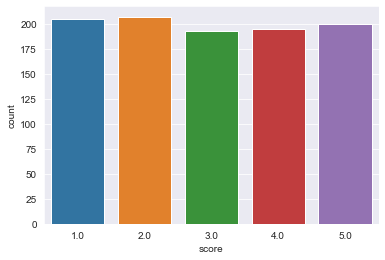

In [3]:
sns.countplot(x="score", data=books_data)

In [25]:
X_balanced, y_balanced = preprocessing.under_sample(np.array(books_data.text).reshape(-1, 1), books_data.score)
X_balanced = [sent[0] for sent in X_balanced]

<AxesSubplot: xlabel='score', ylabel='count'>

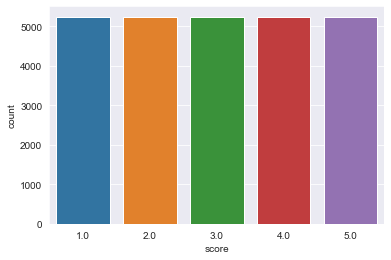

In [26]:
sns.countplot(x="score", data=pd.DataFrame(y_balanced))

In [4]:
X_tokenized = preprocessing.tokenize(books_data.review)

In [5]:
vocab = set([word for sent in X_tokenized for word in sent])
word_index = {}
index = 1
for word in vocab:
    word_index[word] = index
    index += 1

In [6]:
X_indexed = [[word_index[word] for word in sent] for sent in X_tokenized]

In [7]:
X_padded = preprocessing.nn_pad(X_indexed, None)

In [8]:
y_one_hot = preprocessing.one_hot_encode(books_data.score)

In [9]:
X_train, X_test, y_train_one_hot, y_test_one_hot = train_test_split(X_padded, y_one_hot, test_size=0.20,
                                                                    random_state=42)

In [10]:
embeddings_matrix = preprocessing.create_embeddings_matrix(word_index)
input_length = len(X_padded[0])

In [12]:
def tcn_model(input_length, emb_matrix):
    inp = Input(shape=(input_length,))
    x = Embedding(input_dim=embeddings_matrix.shape[0],
                  output_dim=embeddings_matrix.shape[1],
                  input_length=input_length,
                  # Assign the embedding weight with word2vec embedding marix
                  weights=[emb_matrix],
                  # Set the weight to be not trainable (static)
                  trainable=False)(inp)

    x = SpatialDropout1D(0.1)(x)

    x = TCN(128, dilations=[1, 2, 4], return_sequences=True, activation='relu', name='tcn1')(x)
    x = TCN(64, dilations=[1, 2, 4], return_sequences=True, activation='relu', name='tcn2')(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)

    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(5, activation="softmax")(conc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [13]:
deep_model = tcn_model(input_length, embeddings_matrix)
print(deep_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 724)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 724, 300)     4985400     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 724, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 tcn1 (TCN)                     (None, 724, 128)     400256      ['spatial_dropout1d[0][0]']  

In [14]:
BATCH_SIZE = 1024
EPOCHS = 8

history = deep_model.fit(X_train, y_train_one_hot, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/8
1/1 [==============================] - 63s 63s/step - loss: 6.6220 - accuracy: 0.1984 - val_loss: 2.2815 - val_accuracy: 0.2062
Epoch 2/8
1/1 [==============================] - 46s 46s/step - loss: 2.4991 - accuracy: 0.1875 - val_loss: 1.9082 - val_accuracy: 0.2313
Epoch 3/8
1/1 [==============================] - 36s 36s/step - loss: 2.0995 - accuracy: 0.1922 - val_loss: 1.6648 - val_accuracy: 0.2688
Epoch 4/8
1/1 [==============================] - 39s 39s/step - loss: 1.7478 - accuracy: 0.1922 - val_loss: 1.6552 - val_accuracy: 0.2062
Epoch 5/8
1/1 [==============================] - 48s 48s/step - loss: 1.6624 - accuracy: 0.1953 - val_loss: 1.6239 - val_accuracy: 0.2250
Epoch 6/8
1/1 [==============================] - 35s 35s/step - loss: 1.6141 - accuracy: 0.2422 - val_loss: 1.6073 - val_accuracy: 0.1875
Epoch 7/8
1/1 [==============================] - 32s 32s/step - loss: 1.6141 - accuracy: 0.2016 - val_loss: 1.6090 - val_accuracy: 0.2125
Epoch 8/8
1/1 [===================

In [15]:
predictions_one_hot = deep_model.predict(X_test)
predictions = [list(one_hot).index(max(one_hot)) + 1 for one_hot in predictions_one_hot]
y_test = [list(one_hot).index(max(one_hot)) + 1 for one_hot in y_test_one_hot]
print("     MSE:", mean_squared_error(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

     MSE: 6.865
Accuracy: 0.185


In [37]:
def get_nn_classifier(embeddings_matrix, input_length):
    model = Sequential()

    embedding_layer = Embedding(
        embeddings_matrix.shape[0],
        embeddings_matrix.shape[1],
        weights=[embeddings_matrix],
        input_length=input_length,
        trainable=False
    )
    model.add(embedding_layer)

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [38]:
model = get_nn_classifier(embeddings_matrix, input_length)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2117, 300)         29217300  
                                                                 
 flatten_2 (Flatten)         (None, 635100)            0         
                                                                 
 dropout (Dropout)           (None, 635100)            0         
                                                                 
 dense_6 (Dense)             (None, 32)                20323232  
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 5)                

In [ ]:
BATCH_SIZE = 1024
EPOCHS = 8

history = model.fit(X_train, y_train_one_hot, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/8
13/13 [==============================] - 314s 22s/step - loss: 1.5878 - accuracy: 0.2621 - val_loss: 1.5333 - val_accuracy: 0.3206
Epoch 2/8
13/13 [==============================] - 224s 17s/step - loss: 1.3910 - accuracy: 0.4032 - val_loss: 1.4888 - val_accuracy: 0.3494
Epoch 3/8
 9/13 [===================>..........] - ETA: 1:31:08 - loss: 1.2091 - accuracy: 0.5052

In [18]:
predictions_one_hot = model.predict(X_test)
predictions = [list(one_hot).index(max(one_hot)) + 1 for one_hot in predictions_one_hot]
y_test = [list(one_hot).index(max(one_hot)) + 1 for one_hot in y_test_one_hot]
print("     MSE:", mean_squared_error(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

     MSE: 2.32525
Accuracy: 0.3505


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, books_data.score, test_size=0.20, random_state=42)

In [20]:
model = preprocessing.get_nn_linear(embeddings_matrix, input_length)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2117, 300)         29217300  
                                                                 
 flatten_1 (Flatten)         (None, 635100)            0         
                                                                 
 dense_3 (Dense)             (None, 32)                20323232  
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 49,541,621
Trainable params: 20,324,321
Non-trainable params: 29,217,300
_________________________________________________________________
None


In [22]:
BATCH_SIZE = 1024
EPOCHS = 8

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/8
13/13 [==============================] - 46s 3s/step - loss: 3.5329 - val_loss: 1.9403
Epoch 2/8
13/13 [==============================] - 32s 2s/step - loss: 2.2718 - val_loss: 1.7023
Epoch 3/8
13/13 [==============================] - 31s 2s/step - loss: 2.0723 - val_loss: 1.6369
Epoch 4/8
13/13 [==============================] - 31s 2s/step - loss: 1.0471 - val_loss: 1.6263
Epoch 5/8
13/13 [==============================] - 32s 2s/step - loss: 0.7494 - val_loss: 1.6273
Epoch 6/8
13/13 [==============================] - 32s 2s/step - loss: 0.5884 - val_loss: 1.6530
Epoch 7/8
13/13 [==============================] - 32s 2s/step - loss: 0.4669 - val_loss: 1.7128
Epoch 8/8
13/13 [==============================] - 34s 3s/step - loss: 0.3795 - val_loss: 1.7406


In [34]:
predictions_decimal = model.predict(X_test)
predictions = [max(min(round(prediction[0]), 5), 1) for prediction in predictions_decimal]
print("     MSE:", mean_squared_error(y_test, predictions))
print("     MSE:", mean_squared_error(y_test, predictions_decimal))
print("Accuracy:", accuracy_score(y_test, predictions))

     MSE: 1.85025
     MSE: 1.8034910509345174
Accuracy: 0.29225


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Create a grouped bar chart, with job as the x-axis
# and gender as the variable we're grouping on so there
# are two bars per job.
fig, ax = plt.subplots()

# Our x-axis. We basically just want a list
# of numbers from zero with a value for each
# of our jobs.
xs = np.arange(2)

# Define bar width. We need this to offset the second bar.
bar_width = 0.4

b1 = ax.bar(xs, [0.55, 0.39], width=bar_width, label='Naive Bayes')
# Same thing, but offset the x.
b2 = ax.bar(xs + bar_width, [0.56, 0.33], width=bar_width, label='Neural Network')

# Fix the x-axes.
ax.set_xticks(xs + bar_width / 2)
ax.set_xticklabels(["Unbalanced", "Balanced"])

# Add legend.
ax.legend()

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add axis and chart labels.
ax.set_ylabel('Accuracy', labelpad=15)
ax.set_title('Model accuracies', pad=15)

fig.tight_layout()